In [2]:
import numpy as np
import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from optuna import Trial, Study
from braindecode.models import EEGNetv4, HybridNet, EEGResNet, TCN, EEGInceptionMI
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from utils.training import train, best_torch_device
from torchinfo import summary
from copy import copy, deepcopy
from prepare_data import get_frequency_dataloader, get_raw_dataloader, get_sub1_dataloader, get_time_series_dataloader

%load_ext autoreload
%autoreload 2

In [3]:
bsz = 64

train_loader, val_loader, test_loader = get_raw_dataloader(batch_size=bsz)
train_aug_loader, _, _ = get_frequency_dataloader(batch_size=bsz)
train_sub_loader, val_sub_loader, test_sub_loader = get_sub1_dataloader(batch_size=bsz)


In [8]:
class RNN(nn.Module):

    def __init__(self):
        super(RNN, self).__init__()

        self.tdd = nn.Sequential(
            nn.Linear(22, 40),
            nn.ReLU(),
            nn.BatchNorm1d(1000),
            nn.Dropout(0.5),
        )
        
        self.chnnelwise_linear = nn.Sequential(
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.bn = nn.BatchNorm1d(40)


        self.num_layers = 4 # 3, 4
        self.hidden_size = 50 # 20
        self.lstm = nn.LSTM(
            input_size=40,
            hidden_size=self.hidden_size,
            dropout=0.5,
            num_layers=self.num_layers,
            batch_first=True,
        )

        self.linear2 = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(20),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Dropout(0.5),
            nn.LazyLinear(out_features=4),
        )

        self.softmax = nn.Softmax(dim=1)  # the dim corresponds to num_output_classes=4

    def forward(self, x):
        """
        x should have shape (N, H, L) = (N, 22, 1000), where
            L = sequence length
            N = batch size
            H = input size
        """
        x = x.permute(0, 2, 1) # (N, 1000, 22)
        x = self.tdd(x) # (N, 1000, 40)

        x = x.permute(0, 2, 1) # (N, 40, 1000)
        # x = self.chnnelwise_linear(x)
        x = self.bn(x)
        x = x.permute(0, 2, 1)

        # device = torch.device('mps')
        # h0 = torch.randn(self.num_layers, self.hidden_size).to(device)
        # c0 = torch.randn(self.num_layers, self.hidden_size).to(device)
        x, _ = self.lstm(x)

        x = self.linear2(x[:, 9::10, :])

        x = self.softmax(x)
        return x

In [5]:
device = torch.device('mps')

model = RNN()
model = model.to(device)
print(model)
summary(model, input_size=(2, 22, 1000), device='mps')

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RNN(
  (tdd): Sequential(
    (0): Linear(in_features=22, out_features=40, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (chnnelwise_linear): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 20, num_layers=3, batch_first=True, dropout=0.5)
  (linear2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=20, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LazyLinear(in_features=0, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)


Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [2, 4]                    500,500
├─Sequential: 1-1                        [2, 1000, 40]             --
│    └─Linear: 2-1                       [2, 1000, 40]             920
│    └─ReLU: 2-2                         [2, 1000, 40]             --
│    └─BatchNorm1d: 2-3                  [2, 1000, 40]             2,000
│    └─Dropout: 2-4                      [2, 1000, 40]             --
├─BatchNorm1d: 1-2                       [2, 40, 1000]             80
├─LSTM: 1-3                              [2, 1000, 20]             11,680
├─Sequential: 1-4                        [2, 4]                    --
│    └─Flatten: 2-5                      [2, 2000]                 --
│    └─Linear: 2-6                       [2, 20]                   40,020
│    └─ReLU: 2-7                         [2, 20]                   --
│    └─BatchNorm1d: 2-8                  [2, 20]                   4

In [6]:
from utils.training import train

raw_model = model
raw_model.to(device)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=30,
    scheduler=scheduler,
    cp_path="models/rnn",
    cp_filename="raw.pt",
    n_epochs=100,
    show_progress_bar=True,
)

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: mps


Epoch 0: 100%|██████████| 14/14 [00:12<00:00,  1.10batch/s, loss=1.3737]


[Epoch 0] val_acc=0.242604 train_acc=0.262802 val_loss=0.012314 train_loss=0.010924
Validation loss decreased (inf --> 0.012314).  Saving model ...


Epoch 1:   7%|▋         | 1/14 [00:01<00:20,  1.56s/batch, loss=1.3765]


KeyboardInterrupt: 

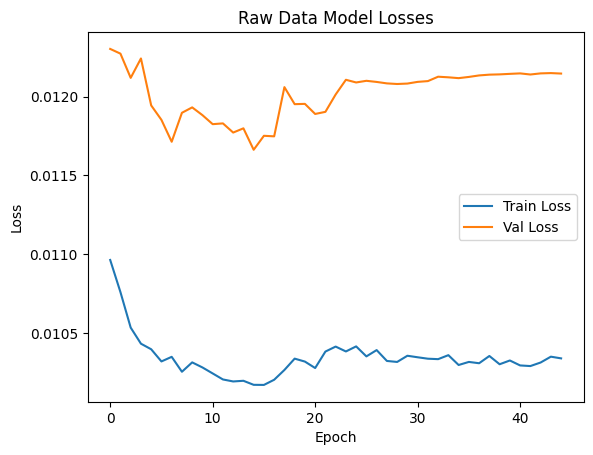

In [22]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

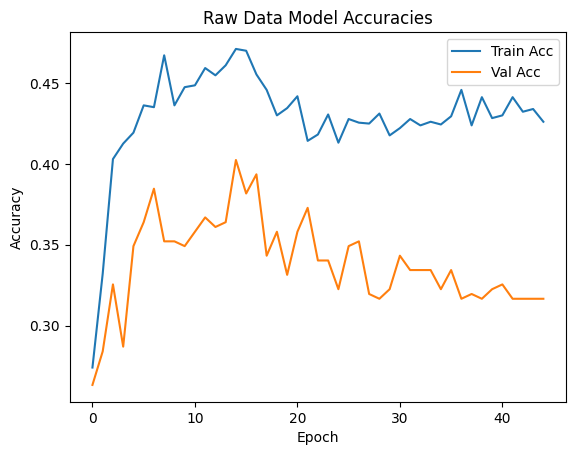

In [23]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [25]:
# Load best model and test
raw_model = torch.load("models/rnn/raw.pt")
raw_model.to(device)
raw_model.eval()

AttributeError: Can't get attribute 'CNN' on <module '__main__'>

In [55]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.7291


In [10]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_sub_loader:
        X, y = X.to(device), y.to(device)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_sub_loader.dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [17]:
aug_model = RNN()
aug_model.to(device)

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RNN(
  (tdd): Sequential(
    (0): Linear(in_features=22, out_features=40, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (chnnelwise_linear): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 50, num_layers=4, batch_first=True, dropout=0.5)
  (linear2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=20, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LazyLinear(in_features=0, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [18]:
optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_aug_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=aug_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=30,
    scheduler=scheduler,
    cp_path="models/rnn",
    cp_filename="aug.pt",
    n_epochs=100,
    show_progress_bar=True,
)

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: mps


Epoch 0: 100%|██████████| 14/14 [00:11<00:00,  1.24batch/s, loss=1.3920]


[Epoch 0] val_acc=0.242604 train_acc=0.259989 val_loss=0.012317 train_loss=0.010936
Validation loss decreased (inf --> 0.012317).  Saving model ...


Epoch 1: 100%|██████████| 14/14 [00:09<00:00,  1.41batch/s, loss=1.3891]


[Epoch 1] val_acc=0.242604 train_acc=0.258863 val_loss=0.012317 train_loss=0.010962
EarlyStopping counter: 1 out of 30


Epoch 2: 100%|██████████| 14/14 [00:09<00:00,  1.42batch/s, loss=1.3720]


[Epoch 2] val_acc=0.242604 train_acc=0.248734 val_loss=0.012316 train_loss=0.010970
EarlyStopping counter: 2 out of 30


Epoch 3: 100%|██████████| 14/14 [00:09<00:00,  1.43batch/s, loss=1.3970]


[Epoch 3] val_acc=0.236686 train_acc=0.238042 val_loss=0.012315 train_loss=0.010988
Validation loss decreased (0.012317 --> 0.012315).  Saving model ...


Epoch 4: 100%|██████████| 14/14 [00:09<00:00,  1.42batch/s, loss=1.3950]


[Epoch 4] val_acc=0.233728 train_acc=0.234665 val_loss=0.012313 train_loss=0.011000
Validation loss decreased (0.012315 --> 0.012313).  Saving model ...


Epoch 5: 100%|██████████| 14/14 [00:09<00:00,  1.41batch/s, loss=1.3777]


[Epoch 5] val_acc=0.224852 train_acc=0.248734 val_loss=0.012311 train_loss=0.010962
Validation loss decreased (0.012313 --> 0.012311).  Saving model ...


Epoch 6: 100%|██████████| 14/14 [00:09<00:00,  1.42batch/s, loss=1.3860]


[Epoch 6] val_acc=0.239645 train_acc=0.250985 val_loss=0.012311 train_loss=0.010961
EarlyStopping counter: 1 out of 30


Epoch 7:   7%|▋         | 1/14 [00:01<00:18,  1.41s/batch, loss=1.3996]


KeyboardInterrupt: 